In [1]:
from transformers import BertTokenizer

# Load the tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-german-cased')

# Access the vocabulary
vocab = tokenizer.get_vocab()

# Convert the vocabulary to a list of tokens
vocab_list = list(vocab.keys())

vocab_list

/home/mseiferling/.venvs/embed/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


['[PAD]',
 '[unused3001]',
 '[UNK]',
 '[CLS]',
 '[SEP]',
 '[MASK]',
 '##er',
 '##en',
 '##ch',
 'd',
 '##ei',
 '##un',
 '##ie',
 '##st',
 '##in',
 '##an',
 '##es',
 '##ein',
 'a',
 's',
 '##ich',
 'der',
 '##ge',
 '##on',
 'S',
 'w',
 '##te',
 '##ung',
 '##sch',
 '##und',
 'die',
 'v',
 'A',
 '##ar',
 '##or',
 'B',
 'D',
 '##ur',
 '##it',
 'ein',
 'b',
 '##ll',
 'und',
 '##at',
 'z',
 '##as',
 'i',
 '##ten',
 '##hr',
 '##em',
 'in',
 '##us',
 '##gen',
 'n',
 '##al',
 'E',
 'M',
 '##de',
 'K',
 'm',
 '##ter',
 'G',
 '1',
 '##uf',
 'F',
 '##den',
 '##der',
 'er',
 '##lich',
 'f',
 'h',
 '##ach',
 'P',
 '##ber',
 'V',
 '##et',
 'R',
 '##el',
 '##eit',
 'W',
 '##ig',
 'zu',
 '##is',
 '##ra',
 'H',
 '##isch',
 'den',
 'ge',
 'von',
 'T',
 '##icht',
 'des',
 '##am',
 'das',
 'L',
 '##ür',
 'k',
 '##ier',
 '##re',
 '2',
 '##ol',
 '##om',
 'N',
 'I',
 'an',
 '##ut',
 'im',
 '##um',
 '##uch',
 '##and',
 '##ck',
 'g',
 'J',
 '##ben',
 'mit',
 'auf',
 '##ste',
 '##ent',
 '##ion',
 '##ro',
 'ver',

In [8]:
import pandas as pd
from pathlib import Path

# Define file paths
file_path_deu = Path("..") / "data" / "deu.list"
file_path_eng = Path("..") / "data" / "eng.list"
file_path_ned = Path("..") / "data" / "ned.list.PER"

# Function to read and process file into a DataFrame
def read_and_process_file(file_path):
    with open(file_path, 'r',encoding='latin-1') as file:
        lines = file.readlines()
    data = [line.strip().split(' ', 1) for line in lines]
    return pd.DataFrame(data, columns=['NER', 'Entity'])

# Read and process files
NER_df_deu = read_and_process_file(file_path_deu)
NER_df_eng = read_and_process_file(file_path_eng)
NER_df_ned = read_and_process_file(file_path_ned)

# Filter English DataFrame to use only 'PER' entities
NER_df_eng = NER_df_eng[NER_df_eng['NER'] == 'PER']

# Combine all DataFrames
NER_df = pd.concat([NER_df_deu, NER_df_eng, NER_df_ned])

NER_df['NER'] = NER_df['NER'].replace('LOC', 'Ort:')
NER_df['NER'] = NER_df['NER'].replace('PER', 'Person:')
NER_df['NER'] = NER_df['NER'].replace('ORG', 'Organisation:')

# Convert DataFrame to list of elements
def create_training_data(row):
    if row['NER'] == 'MISC':
        return f"{row['Entity']}"
    else:
        return f"{row['NER']} {row['Entity']}"

NER_list = [create_training_data(row) for _, row in NER_df.iterrows()]
NER_list


['Ort: A 5',
 'Ort: A 66',
 'Ort: A 661',
 'Ort: Aalen',
 'Ort: Aare-Mündung',
 'Ort: Abchasien',
 'Ort: Abrams Complex',
 'Ort: Abtei Münsterschwarzach',
 'Ort: Achenbachstraße',
 'Ort: Adalbertstraße',
 'Ort: Adam-und-Eva-Brunnen',
 'Ort: Adria',
 'Ort: Adrianopel',
 'Ort: Affenbrunnen',
 'Ort: Affentorhaus',
 'Ort: Affentorhaus West',
 'Ort: Afrika',
 'Ort: Airlenbach',
 'Ort: Albert-Schweizer-Kinderdorf',
 'Ort: Alexanderstraße',
 'Ort: Alleenring',
 'Ort: Allgäu',
 'Ort: Alma Ata',
 'Ort: Alt-Bergen',
 'Ort: Alte Haus von 1327',
 'Ort: Alte Josefshaus',
 'Ort: Alten Brücke',
 'Ort: Altenbuch',
 'Ort: ALTENBURG',
 'Ort: Alten Frankfurter Straße',
 'Ort: Altenhilfe-Zentrum',
 'Ort: Altenwohnheim',
 'Ort: Alte Oper',
 'Ort: Alter Kirchhainer Weg',
 'Ort: Altertumsmuseum',
 'Ort: Alte Schulstraße',
 'Ort: Alt-Heidelberg',
 'Ort: Altmünstermühle',
 'Ort: Alt-Nied',
 'Ort: Alt-Niederursel',
 'Ort: Alt-Sachsenhausen',
 'Ort: AltSachsenhausens',
 'Ort: AltSchwanheim',
 'Ort: Alt-Schwanhei

In [9]:
import pandas as pd
import torch
from transformers import BertTokenizer, BertModel

tokenizer = BertTokenizer.from_pretrained('bert-base-german-cased')
model = BertModel.from_pretrained('bert-base-german-cased')

vocab_size = tokenizer.vocab_size

# Function to get embeddings for a list of tokens
def get_embeddings(tokens):
    with torch.no_grad():
        outputs = model(**{k: torch.tensor(v).unsqueeze(0) for k, v in tokens.items()})
    return outputs.last_hidden_state.squeeze(0)

# Process each element in NER_list
rows = []
for element in NER_list[:10]:
    
    full_tokens = tokenizer(element, padding=False, truncation=False, add_special_tokens=True)
    
    # Get embeddings for the full tokenized input
    full_embeddings = get_embeddings(full_tokens)
    
    # Split the element into NER type and entity
    parts = element.split(': ', 1)
    entity = parts[1] if len(parts) > 1 else element
    
    # Tokenize the entity separately (without special tokens)
    entity_tokens = tokenizer(entity, padding=False, truncation=False, add_special_tokens=False)
    
    # Find the start index of entity tokens in the full tokenization
    start_index = 1  # Skip [CLS]
    if len(parts) > 1:
        start_index += len(tokenizer(parts[0] + ':', add_special_tokens=False)['input_ids'])
    
    # Process each token in the entity
    tokens = []
    token_ids = []
    token_embeddings = []
    for i, token_id in enumerate(entity_tokens['input_ids']):
        token = tokenizer.decode([token_id])
        token_embedding = full_embeddings[start_index + i]
        
        tokens.append(token)
        token_ids.append(token_id)
        token_embeddings.append(token_embedding.tolist())
    
    # Add the end of sequence token ID
    token_ids.append(4)
    
    # Calculate average embedding for the entity tokens
    avg_embedding = torch.mean(full_embeddings[start_index:start_index+len(entity_tokens['input_ids'])], dim=0).tolist()
    
    
    rows.append({
        'Entity': entity,
        'Tokens': tokens,
        'Token_IDs': token_ids,
        'Token_Embeddings': token_embeddings,
        'Average_Embedding': avg_embedding,
        'Target_Token_IDs': token_ids
    })

# Create DataFrame
df = pd.DataFrame(rows)
df

,Entity,Tokens,Token_IDs,Token_Embeddings,Average_Embedding,Target_Token_IDs
0,A 5,"[A, 5]","[32, 435, 4]","[[0.5321837067604065, 0.15855082869529724, 0.2...","[-0.24310854077339172, 0.13687941431999207, -0...","[32, 435, 4]"
1,A 66,"[A, 66]","[32, 10092, 4]","[[0.48714154958724976, 0.30221953988075256, 0....","[0.3266172707080841, 0.14974261820316315, 0.12...","[32, 10092, 4]"
2,A 661,"[A, 66, ##1]","[32, 10092, 26927, 4]","[[0.3334657549858093, 0.23834815621376038, -0....","[0.12139932066202164, 0.24942080676555634, 0.0...","[32, 10092, 26927, 4]"
3,Aalen,"[A, ##alen]","[32, 609, 4]","[[0.07099054753780365, -0.5678781867027283, 1....","[-0.003419943153858185, -0.26080992817878723, ...","[32, 609, 4]"
4,Aare-Mündung,"[Aar, ##e, -, Mündung]","[15576, 26897, 26935, 14955, 4]","[[0.33789581060409546, -0.5541059374809265, -0...","[0.21876320242881775, -0.3105975091457367, 0.0...","[15576, 26897, 26935, 14955, 4]"
5,Abchasien,"[Ab, ##ch, ##asien]","[226, 8, 11254, 4]","[[-0.13087157905101776, 0.12063128501176834, -...","[-0.1908833384513855, 0.09819001704454422, 0.2...","[226, 8, 11254, 4]"
6,Abrams Complex,"[Ab, ##ram, ##s, Comp, ##lex]","[226, 1021, 26902, 3341, 1728, 4]","[[0.5068281292915344, 0.3484358787536621, -0.0...","[0.4298573434352875, 0.3628302812576294, -0.17...","[226, 1021, 26902, 3341, 1728, 4]"
7,Abtei Münsterschwarzach,"[Abtei, Münster, ##schw, ##arz, ##ach]","[16081, 6717, 2528, 15890, 71, 4]","[[0.40379682183265686, -0.48086002469062805, -...","[0.20161636173725128, -0.289083331823349, 0.51...","[16081, 6717, 2528, 15890, 71, 4]"
8,Achenbachstraße,"[Ach, ##en, ##bachs, ##tra, ##ße]","[5534, 7, 18436, 277, 508, 4]","[[0.25991660356521606, 0.16852140426635742, -0...","[0.4882625639438629, 0.2792228162288666, -0.11...","[5534, 7, 18436, 277, 508, 4]"
9,Adalbertstraße,"[Ad, ##alb, ##erts, ##tra, ##ße]","[1724, 1586, 22139, 277, 508, 4]","[[-0.7305693626403809, 0.5974432229995728, -0....","[0.29880765080451965, 0.7435340285301208, -0.1...","[1724, 1586, 22139, 277, 508, 4]"


In [10]:
import torch
from torch.utils.data import Dataset, DataLoader, random_split
import numpy as np
from torch.nn.utils.rnn import pad_sequence

class CustomDataset(Dataset):
    def __init__(self, dataframe):
        self.data = dataframe
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        # Get the average embedding (input)
        avg_embedding = torch.tensor(self.data.iloc[idx]['Average_Embedding'], dtype=torch.float32)
        
        # Get the token IDs (target)
        token_ids = torch.tensor(self.data.iloc[idx]['Target_Token_IDs'], dtype=torch.int64)
        
        return avg_embedding, token_ids

def collate_fn(batch):
    # Separate inputs and targets
    inputs, targets = zip(*batch)
    
    # Pad the target sequences
    targets_padded = pad_sequence(targets, batch_first=True, padding_value=0)
    
    # Stack the inputs 
    inputs_stacked = torch.stack(inputs)
    
    return inputs_stacked, targets_padded

# Create the dataset
full_dataset = CustomDataset(df)

# Calculate split sizes
total_size = len(full_dataset)
train_size = int(0.8 * total_size)
val_size = int(0.1 * total_size)
test_size = total_size - train_size - val_size

# Split the dataset
train_dataset, val_dataset, test_dataset = random_split(full_dataset, [train_size, val_size, test_size])

# Create DataLoaders with collate function
train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True, collate_fn=collate_fn) ########### hyperparameter optimization batch size
val_loader = DataLoader(val_dataset, batch_size=2, shuffle=False, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=2, shuffle=False, collate_fn=collate_fn)

# Infromation dataloaders
for loader_name, loader in [("Train", train_loader), ("Validation", val_loader), ("Test", test_loader)]:
    print(f"\nInformation {loader_name} loader:")
    for batch in loader:
        print("Input shape:", batch[0].shape)
        print("Target shape:", batch[1].shape)
        print("Input dtype:", batch[0].dtype)
        print("Target dtype:", batch[1].dtype)
        print("Input range:", batch[0].min().item(), batch[0].max().item())
        print("Target range:", batch[1].min().item(), batch[1].max().item())
        break


Information Train loader:
Input shape: torch.Size([2, 768])
Target shape: torch.Size([2, 6])
Input dtype: torch.float32
Target dtype: torch.int64
Input range: -1.956587791442871 14.927659034729004
Target range: 0 26902

Information Validation loader:
Input shape: torch.Size([1, 768])
Target shape: torch.Size([1, 6])
Input dtype: torch.float32
Target dtype: torch.int64
Input range: -1.5262466669082642 12.289899826049805
Target range: 4 18436

Information Test loader:
Input shape: torch.Size([1, 768])
Target shape: torch.Size([1, 6])
Input dtype: torch.float32
Target dtype: torch.int64
Input range: -1.4289337396621704 12.764867782592773
Target range: 4 16081


In [17]:
import torch
import torch.nn as nn
from transformers import BertForMaskedLM
#### Consider adding dropout layers to prevent overfitting.
class CustomLSTMWithBERTMLM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, max_seq_length, bert_model_name):
        super().__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        ####self.dropout = nn.Dropout(0.1)
        ####self.layer_norm = nn.LayerNorm(hidden_size)
        self.max_seq_length = max_seq_length
        
        self.bert_mlm = BertForMaskedLM.from_pretrained(bert_model_name)
        #### Remove these lines to allow fine-tuning
        for param in self.bert_mlm.parameters():
            param.requires_grad = False
        
        assert hidden_size == self.bert_mlm.config.hidden_size, "LSTM hidden size must match BERT hidden size"

    def forward(self, x):
        batch_size = x.size(0)
        
        # Use the input to initialize the hidden state
        h = x.unsqueeze(0).repeat(self.lstm.num_layers, 1, 1) #shape:(num_layers, batch_size, hidden_size)
        c = torch.zeros(self.lstm.num_layers, batch_size, self.lstm.hidden_size).to(x.device)
        
        # dummy input for the LSTM
        dummy_input = torch.zeros(batch_size, 1, self.lstm.hidden_size).to(x.device)
        outputs = []
        for i in range(self.max_seq_length):
            out, (h, c) = self.lstm(dummy_input, (h, c))
            ####out = self.dropout(out)
            ####out = self.layer_norm(out)
            mlm_output = self.bert_mlm.cls(out)
            
            outputs.append(mlm_output)
        
        output_tensor = torch.cat(outputs, dim=1)
        return output_tensor # output shape: (batch_size, generated_seq_length, vocab_size)

# Usage
input_size = 768
hidden_size = 768
num_layers = 2 #### hyperparameter optimization
max_seq_length = 10
bert_model_name = 'bert-base-german-cased'
model = CustomLSTMWithBERTMLM(input_size, hidden_size, num_layers, max_seq_length, bert_model_name)


Some weights of the model checkpoint at bert-base-german-cased were not used when initializing BertForMaskedLM: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Epoch [1/5], Train Loss: 13.3859, Test Loss: 11.0702
Epoch [2/5], Train Loss: 7.0538, Test Loss: 11.1447
Epoch [3/5], Train Loss: 4.8655, Test Loss: 11.0131
Epoch [4/5], Train Loss: 3.0761, Test Loss: 12.1358
Epoch [5/5], Train Loss: 2.5541, Test Loss: 11.9800
Training finished!


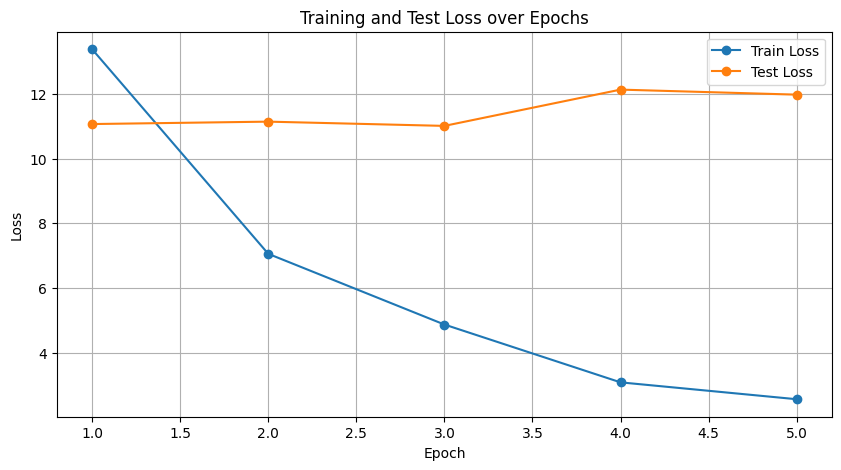

In [13]:
import matplotlib.pyplot as plt
learning_rate = 0.001
# CrossEntropyLoss, expect the inputs in a specific format:
# The predictions should be a 2D tensor of shape [N, C] where N is the number of samples and C is the number of classes (vocab size in this case).
# The targets should be a 1D tensor of shape [N] containing the class indices.
criterion = nn.CrossEntropyLoss(ignore_index=0)  # Ignore padding index
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate) #### no learning rate decay -> could test AdamW

# Training loop
num_epochs = 5

train_losses = []
test_losses = []

for epoch in range(num_epochs):
    epoch_train_losses = []
    for batch in train_loader:
        inputs, targets = batch
        
        # inference with batch
        outputs = model(inputs)
        
        # processing of output and target for training
        outputs = outputs[:, :targets.shape[1], :] # we only need to consider the outputs for which we have a target during training
        outputs = outputs.reshape(-1, outputs.size(-1)) # Reshape outputs from [batch_size, sequence_length, vocab_size] to be [batch_size * sequence_length, vocab_size]  
        targets = targets.reshape(-1) # Reshape targets from [batch_size, sequence_length] to be [batch_size * sequence_length] 

        # Calculate loss
        loss = criterion(outputs, targets)
        
        # Backpropagation and optimization
        optimizer.zero_grad() # this resets the gradients of all parameters to zero from last batch
        loss.backward() # computes the gradient of the loss with respect to each parameter of the model
        optimizer.step() # updates the parameters based on the computed gradients
    
        epoch_train_losses.append(loss.item())
   
    avg_train_loss = sum(epoch_train_losses) / len(epoch_train_losses)
    train_losses.append(avg_train_loss)
    
    # Compute test loss
    model.eval()
    epoch_test_losses = []
    with torch.no_grad():
        for batch in test_loader:
            inputs, targets = batch
            
            outputs = model(inputs)
            
            outputs = outputs[:, :targets.shape[1], :]
            outputs = outputs.reshape(-1, outputs.size(-1))
            targets = targets.reshape(-1)
            
            loss = criterion(outputs, targets)
            
            epoch_test_losses.append(loss.item())
    
    avg_test_loss = sum(epoch_test_losses) / len(epoch_test_losses)
    test_losses.append(avg_test_loss)
    
    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, Test Loss: {avg_test_loss:.4f}")

print("Training finished!")

# Plotting the losses
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), train_losses, marker='o', label='Train Loss')
plt.plot(range(1, num_epochs + 1), test_losses, marker='o', label='Test Loss')
plt.title('Training and Test Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

#### Implement more comprehensive evaluation metrics (e.g., perplexity, BLEU score for generated text).


In [14]:
# # end inference if this token is predicted
# eos_token_id = tokenizer.convert_tokens_to_ids('[SEP]')  # EOS token

# Example forward pass
#input_tensor = torch.randn(1,768)

tensor = torch.tensor(df["Average_Embedding"][6]).unsqueeze(0)
# Generate Gaussian noise
noise_level = 0
noise = torch.randn_like(tensor) * noise_level
# Add noise to tensor
input_tensor = tensor + noise


output_tensor = model(input_tensor)
output_tensor.shape

for batch_idx in range(output_tensor.size(0)):
    for position in range(output_tensor.size(1)):  # Iterate over sequence length
        position_probs = output_tensor[batch_idx, position, :]  # Get probabilities for this position
        
        # Get top 5 probabilities
        top_5_values, top_5_indices = torch.topk(position_probs, 1, dim=0)
        
        print(f"Position {position}:")
        for i, (value, index) in enumerate(zip(top_5_values, top_5_indices), 1):
            token = tokenizer.convert_ids_to_tokens([index.item()])[0]
            probability = value.item()
            print(f"  {i}. {token} (probability: {probability:.4f})")
        print()
        

Position 0:
  1. Ab (probability: 17.0035)

Position 1:
  1. ##ram (probability: 11.8444)

Position 2:
  1. ##tra (probability: 11.1060)

Position 3:
  1. ##tra (probability: 11.0464)

Position 4:
  1. ##ße (probability: 11.1645)

Position 5:
  1. ##ße (probability: 11.5178)

Position 6:
  1. ##ße (probability: 11.7796)

Position 7:
  1. ##ße (probability: 11.9618)

Position 8:
  1. ##ße (probability: 12.0708)

Position 9:
  1. ##ße (probability: 12.1103)



In [16]:
torch.tensor(df["Average_Embedding"][8]).unsqueeze(0).shape

torch.Size([1, 768])